# Analyzing the Trends in Ratings of Complete TV Shows
---

In [2]:
# import libraries
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re

In [3]:
# configure matplotlib
plt.rcParams["figure.figsize"] = 15,10

## Collecting Data From IMDB
---

### Extracting a List of TV Shows

In [133]:
def show_data_extract(page):
    """
    Extract the details of tv shows on an IMDB list
    """
    # send get request
    response = requests.get(page)

    # parse through beautiful soup
    soup = BeautifulSoup(response.content)
    
    # get all shows listed
    listed = soup.find_all("div", attrs={"class": "lister-item-content"})

    # to store all show data
    all_shows_data = []

    # iterate through each show in the list extracting details
    for show in listed:
        # get header
        title = show.find("a").text

        # get relative link on imdb
        rel_link = show.find("a").get("href")

        # get show duration
        duration = show.find("span", attrs={"class": "lister-item-year text-muted unbold"}).text.strip()

        # get runtime
        runtime = show.find("span", attrs={"class": "runtime"}).text.strip()

        # get genre
        genre = show.find("span", attrs={"class": "genre"}).text.strip()

        # get overall rating
        overall_rating = show.find("div", attrs={"class": "inline-block ratings-imdb-rating"}).text.strip()
        
        # get number of ratings
        rating_num = show.find("meta", attrs={"itemprop": "ratingCount"}).get("content")

        # store
        all_shows_data.append({
            "title": title,
            "rel_link": rel_link,
            "duration": duration,
            "runtime": runtime,
            "genre": genre,
            "overall_rating": overall_rating,
            "rating_num": rating_num
        })
    
    return all_shows_data

In [134]:
# three pages of a list of 126 tv shows with more than 100,000 ratings
shows_url_page_1 = r"https://www.imdb.com/search/title?title_type=tv_series" \
                    "&num_votes=100000,&sort=user_rating,desc&view=advanced"

shows_url_page_2 = r"https://www.imdb.com/search/title?title_type=tv_series&" \
                    "num_votes=100000,&sort=user_rating,desc&start=51&ref_=adv_nxt"

shows_url_page_3 = r"https://www.imdb.com/search/title?title_type=tv_series&" \
                    "num_votes=100000,&sort=user_rating,desc&start=101&ref_=adv_nxt"

In [135]:
# to store the details of the tv shows on each page
tv_shows = pd.DataFrame()

# parse each of the pages of the list
for page in [shows_url_page_1, shows_url_page_2, shows_url_page_3]:
    # extract show data and store in the df created above
    tv_shows = tv_shows.append(show_data_extract(page), sort=True)
    
    # pause so we don't overload IMDB's servers
    time.sleep(3)

In [137]:
# turn imdb relative links into absolute links
tv_shows = tv_shows.assign(abs_link = tv_shows["rel_link"].apply(lambda x: "https://www.imdb.com" + x))

In [138]:
# based on the duration, mark shows as complete or ongoing
# (shortcut: if the second digit from the last is an empty space and not a number, it's not complete)
tv_shows = tv_shows.assign(status = tv_shows["duration"].apply(lambda x: x[-2].isdigit()))

In [139]:
# backup the complete list of tv shows
tv_shows.to_csv("tv_shows.csv", index=False, encoding="utf-8")

In [140]:
# filter down to a list of completed tv show
complete_shows = tv_shows[tv_shows.status == True]

In [141]:
# reset index
complete_shows = complete_shows.reset_index(drop=True)

### Extracting the Ratings of All Episodes of Each TV Show

In [250]:
def episode_data_extract(page, show):
    """
    Extract episodes from all season pages for an IMDB show
    """
    # form url of first episodes page
    ratings_page = f"{page}episodes"
    
    # send get request
    try:
        response = requests.get(ratings_page)
    # if it fails, pause and try again
    except:
        time.sleep(10)
        response = requests.get(ratings_page)
    
    # parse with bs4
    soup = BeautifulSoup(response.content, "html.parser")
    
    # get number of seasons from drop down (remove seasons with no number i.e., bonus stuff)
    num_of_seasons = max([int(x) for x in soup.find("select", attrs={"id": "bySeason"}).text.split() if x.isdigit()])
    
    # create list to store all episode information
    all_episode_info = []
    
    # pause to prevent overloading servers
    time.sleep(2)
    
    # go through all season pages extracting episode data
    for season_num in range(1,num_of_seasons+1):
        # for url of season page
        season_page = f"{page}episodes?season={season_num}"
        
        # send get request
        try:
            response = requests.get(season_page)
        # if it fails pause and try again
        except:
            time.sleep(10)
            response = requests.get(season_page)
        
        # parse with bs4
        soup = BeautifulSoup(response.content, "html.parser")
        
        # get list of all episodes
        episodes = soup.find_all("div", attrs={"itemprop": "episodes"})
        
        # iterate through list extracting data
        for episode in episodes:
            # get title
            title = episode.find("a", attrs={"itemprop": "name"}).text

            # get episode relative link
            rel_link = episode.find("a", attrs={"itemprop": "name"}).get("href")
            
            # get the episode date
            episode_date = episode.find("div", attrs={"class": "airdate"}).text.strip()

            # get episode rating
            try:
                rating = episode.find("span", attrs={"class": "ipl-rating-star__rating"}).text
            except:
                rating = "Unrated"

            # get number of votes
            try:
                votes = episode.find("span", attrs={"class": "ipl-rating-star__total-votes"}).text
            except:
                votes = "Unrated"

            # get episode number
            episode_number = episode.find("meta", attrs={"itemprop": "episodeNumber"}).get("content")
            
            # store all data
            all_episode_info.append({
                "show": show,
                "season_num": season_num,
                "title": title,
                "rel_link": rel_link,
                "episode_date": episode_date,
                "rating": rating,
                "votes": votes,
                "episode_number": episode_number
            })
            
        # pause before proceeding to the next season
        print(f"{show} -- Season {season_num} complete!")
        time.sleep(3)
    
    return all_episode_info

In [ ]:
# to store all episode information
episode_ratings = pd.DataFrame()

In [252]:
# iterate through all shows extracting the ratings of all epsiodes across all seasons
for show_details in complete_shows.iterrows():
    # skip shows we already extracted (use when program crashes)
    if show_details[0] in [x for x in range(0,36)]:
        continue
    
    # get name and imdb link of show
    show_name = show_details[1].title
    page = show_details[1].abs_link
    
    # extract and store episode data
    episode_ratings = episode_ratings.append(episode_data_extract(page, show_name), sort=True)
    
    # backup so we don't lose all our data in case something happens
    episode_ratings.to_csv("episodes_backup.csv", index=False, encoding="utf-8")
    
    # pause before proceeding to next show
    time.sleep(2)

Prison Break -- Season 1 complete!
Prison Break -- Season 2 complete!
Prison Break -- Season 3 complete!
Prison Break -- Season 4 complete!
Prison Break -- Season 5 complete!
Prison Break -- Season 6 complete!
Lost -- Season 1 complete!
Lost -- Season 2 complete!
Lost -- Season 3 complete!
Lost -- Season 4 complete!
Lost -- Season 5 complete!
Lost -- Season 6 complete!
Scrubs -- Season 1 complete!
Scrubs -- Season 2 complete!
Scrubs -- Season 3 complete!
Scrubs -- Season 4 complete!
Scrubs -- Season 5 complete!
Scrubs -- Season 6 complete!
Scrubs -- Season 7 complete!
Scrubs -- Season 8 complete!
Scrubs -- Season 9 complete!
24 -- Season 1 complete!
24 -- Season 2 complete!
24 -- Season 3 complete!
24 -- Season 4 complete!
24 -- Season 5 complete!
24 -- Season 6 complete!
24 -- Season 7 complete!
24 -- Season 8 complete!
The Originals -- Season 1 complete!
The Originals -- Season 2 complete!
The Originals -- Season 3 complete!
The Originals -- Season 4 complete!
The Originals -- Season

Two and a Half Men -- Season 3 complete!
Two and a Half Men -- Season 4 complete!
Two and a Half Men -- Season 5 complete!
Two and a Half Men -- Season 6 complete!
Two and a Half Men -- Season 7 complete!
Two and a Half Men -- Season 8 complete!
Two and a Half Men -- Season 9 complete!
Two and a Half Men -- Season 10 complete!
Two and a Half Men -- Season 11 complete!
Two and a Half Men -- Season 12 complete!
Glee -- Season 1 complete!
Glee -- Season 2 complete!
Glee -- Season 3 complete!
Glee -- Season 4 complete!
Glee -- Season 5 complete!
Glee -- Season 6 complete!
Iron Fist -- Season 1 complete!
Iron Fist -- Season 2 complete!


In [258]:
# check if there are any duplicates that need to be dropped
len(episode_ratings) == len(episode_ratings.drop_duplicates())

True

In [302]:
# drop all episodes with an unrated rating (most likely to be upcoming episode placeholders)
only_rated = episode_ratings[episode_ratings.rating != "Unrated"]

In [303]:
# change var types
only_rated = only_rated.assign(formatted_date = pd.to_datetime(only_rated.episode_date))
only_rated.rating = only_rated.rating.astype("float")
only_rated = only_rated.assign(formatted_votes = only_rated.votes.apply(lambda x: int(x[1:-1].replace(",", ""))))

In [305]:
# make backup
only_rated.to_csv("only_rated_episodes.csv", index=False, encoding="utf-8")

## Analyzing the Data

---

In [76]:
# import backups

# tv shows
tv_shows = pd.read_csv("tv_shows.csv")
complete_shows = tv_shows[tv_shows.status == True]
complete_shows = complete_shows.reset_index(drop=True)

# episode ratings
only_rated = pd.read_csv("only_rated_episodes.csv", parse_dates=True)
only_rated = only_rated.assign(formatted_date = pd.to_datetime(only_rated.episode_date))

In [77]:
# calculate the average rating per season for each tv show
season_avg = only_rated.groupby(["show", "season_num"])["rating"].mean().reset_index()

### Average Ratings Per Season for the Top 20 TV Shows (By Overall Rating)

In [78]:
# get top 20 tv shows
top20_tv = complete_shows.sort_values("overall_rating", ascending=False)["title"].iloc[:20].tolist()

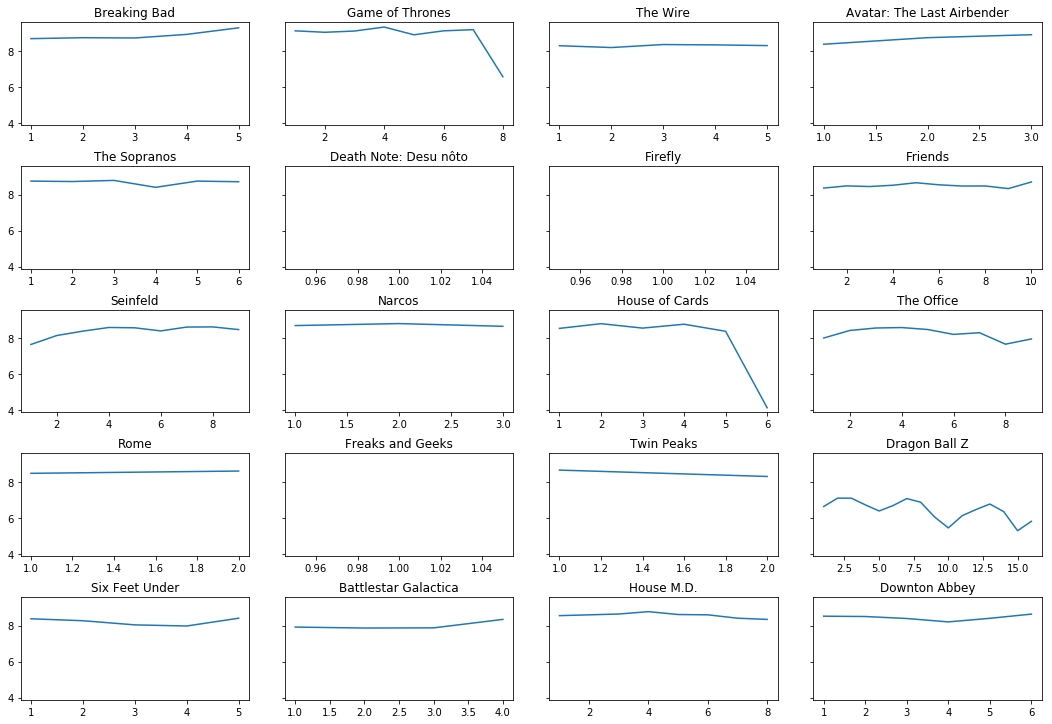

In [79]:
## FIX THIS -- MAKE IT NICER

# plot the average rating per season for all shows

# setup
f, ax = plt.subplots(nrows=5, ncols=4, sharey=True)
ax = ax.ravel()
f.tight_layout(
    h_pad=2,
    w_pad=2
)

for pos, show in enumerate(top20_tv):
    # plot
    vis1 = sns.lineplot(
        data=season_avg[season_avg.show == show],
        x="season_num",
        y="rating",
        ax=ax[pos]
    )
    
    # label
    vis1.set_title(show)
    vis1.set_xlabel("")
    vis1.set_ylabel("")

plt.show()

### Average Ratings Per Season for the Bottom 20 TV Shows (By Overall Rating)

In [ ]:
# to-do